{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2051, 'height': 2051, 'count': 10, 'crs': CRS.from_epsg(32647), 'transform': Affine(10.0, 0.0, 754360.0,
       0.0, -10.0, 1688690.0), 'tiled': False, 'interleave': 'pixel'}


(-0.5, 2050.5, 2050.5, -0.5)

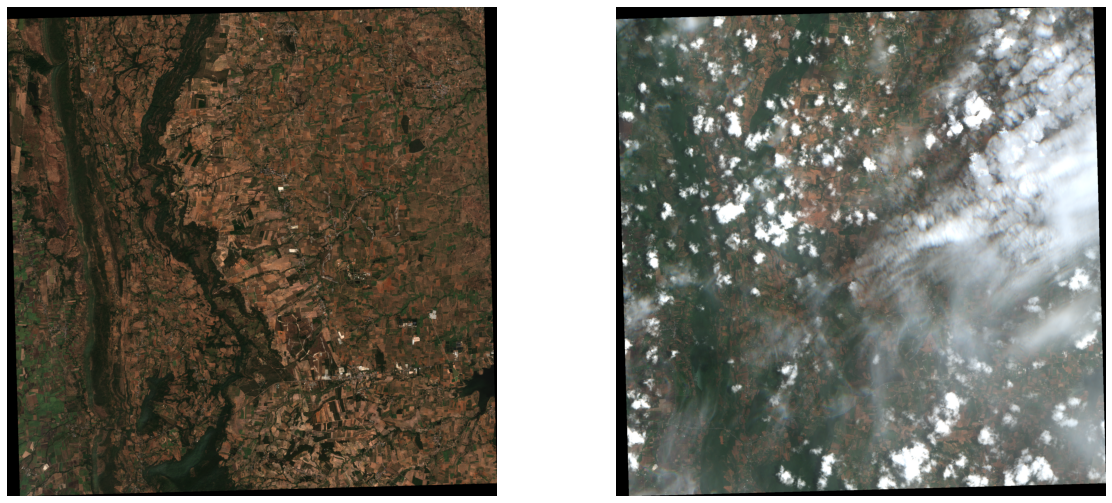

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import random
from rasterio.features import rasterize
from sklearn.feature_extraction.image import extract_patches_2d

def normalize_color(arr):
    # Normalize values to 0-255 (actual value is 0-4096)
    arr = np.clip(arr, 0, 4096)
    arr = (arr * 255) / arr.max()
    return arr.astype(np.uint8)


jan_dataset = rasterio.open('data/raw/image/20210101/dankhuntod_47PQS_20210101_S2ABands_stk.tif')
feb_dataset = rasterio.open('data/raw/image/20210205/dankhuntod_47PQS_20210205_S2ABands_stk.tif')
mar_dataset = rasterio.open('data/raw/image/20210302/dankhuntod_47PQS_20210302_S2ABands_stk.tif')
apr_dataset = rasterio.open('data/raw/image/20210401/dankhuntod_47PQS_20210401_S2ABands_stk.tif')
may_dataset = rasterio.open('data/raw/image/20210501/dankhuntod_47PQS_20210501_S2ABands_stk.tif')
jun_dataset = rasterio.open('data/raw/image/20210605/dankhuntod_47PQS_20210605_S2ABands_stk.tif')

dataset_profile = jan_dataset.profile
print(dataset_profile)

plt.figure(figsize=(20,9))
plt.subplot(121)
plt.imshow(normalize_color(np.stack([jan_dataset.read(3), jan_dataset.read(2), jan_dataset.read(1)], axis=-1)))
plt.axis('off')
plt.subplot(122)
plt.imshow(normalize_color(np.stack([may_dataset.read(3), may_dataset.read(2), may_dataset.read(1)], axis=-1)))
plt.axis('off')

(-0.5, 2050.5, 2050.5, -0.5)

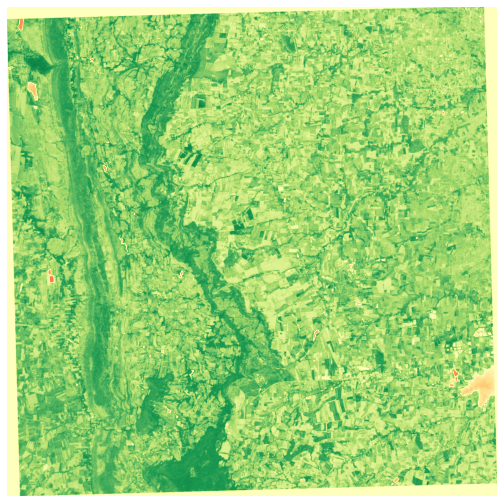

In [3]:
datasets = {
    '01': jan_dataset,
    '02': feb_dataset,
    '03': mar_dataset,
    '04': apr_dataset,
    '05': may_dataset,
    '06': jun_dataset
}

ndvis = {}
for month, ds in datasets.items():
    data = np.stack([ds.read(i+1) for i in range(ds.profile['count'])])
    red = data[2]
    nir = data[7]
    ndvi = np.divide((nir - red), (nir + red), out=np.zeros_like(red), where=(nir + red) != 0)
    ndvis[month] = ndvi

plt.figure(figsize=(9,9))
plt.imshow(ndvis['01'], cmap='RdYlGn', vmin=-1, vmax=1)
plt.axis('off')


{'cassava': 1, 'maize': 2, 'rice': 3, 'sugarcane': 4}


(-0.5, 2050.5, 2050.5, -0.5)

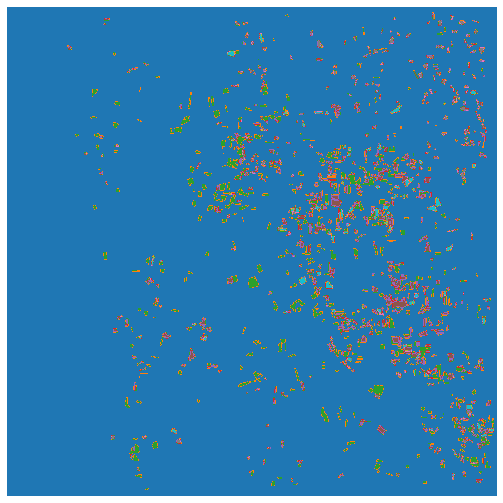

In [4]:
label_data = geopandas.read_file('data/raw/shape/training_30.shp').to_crs(32647)
class_map = {crop_type : i+1 for i, crop_type in enumerate(label_data['crop_type'].unique())}
print(class_map)
label_data['crop_type'] = label_data['crop_type'].map(class_map)

label_image = rasterize(
    shapes=[(row.geometry, row.crop_type) for i, row in label_data.iterrows()], 
    out_shape=(dataset_profile['height'], dataset_profile['width']),
    transform=dataset_profile['transform'],
    fill=0,
    dtype=rasterio.uint8
)
plt.figure(figsize=(9,9))
plt.imshow(label_image, cmap='tab10')
plt.axis('off')

In [5]:
PATCH_HEIGHT = 64
PATCH_WIDTH = 64

ndvi_img = np.stack([
    ndvis['01'],
    ndvis['02'],
    ndvis['03'],
    ndvis['04'],
    ndvis['05'],
    ndvis['06']], axis=0)

ndvi_patches = extract_patches_2d(ndvi_img.transpose(1,2,0), patch_size=(PATCH_HEIGHT,PATCH_WIDTH), max_patches=25000, random_state=15)
label_patches = extract_patches_2d(label_image, patch_size=(PATCH_HEIGHT,PATCH_WIDTH), max_patches=25000, random_state=15)

non_empty_patches = []
for i in range(label_patches.shape[0]):
    if np.count_nonzero(label_patches[i]) > int(0.25 * (PATCH_HEIGHT * PATCH_WIDTH)):
        non_empty_patches.append(i)
random.shuffle(non_empty_patches)

ndvi_patches = ndvi_patches[non_empty_patches]
label_patches = label_patches[non_empty_patches]

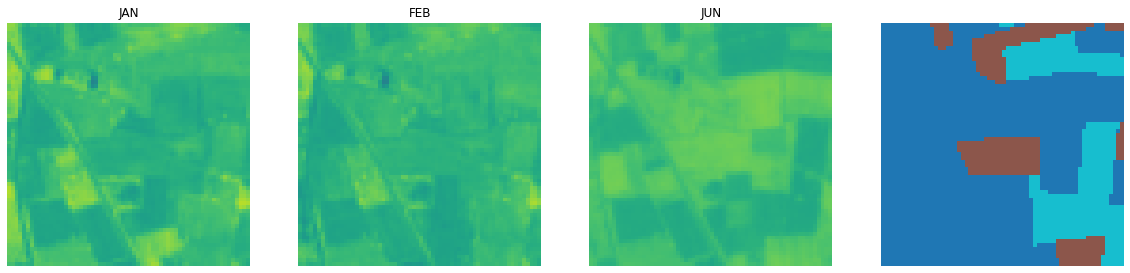

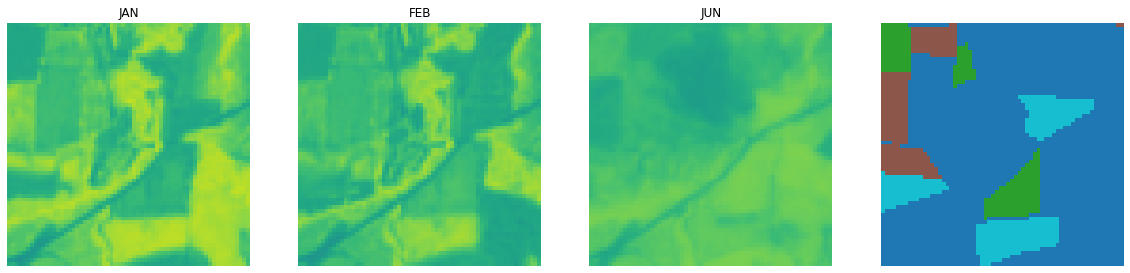

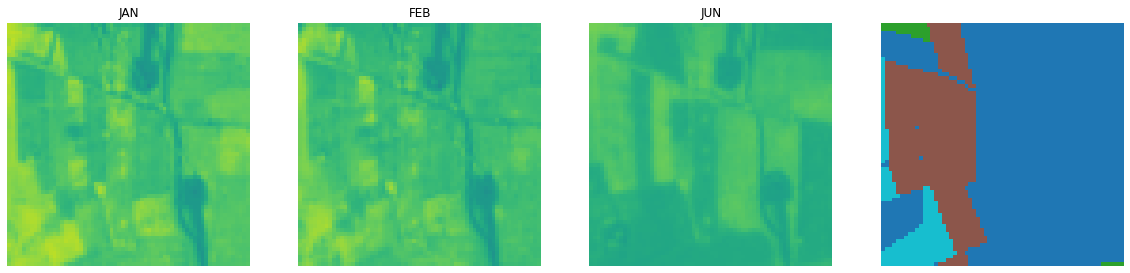

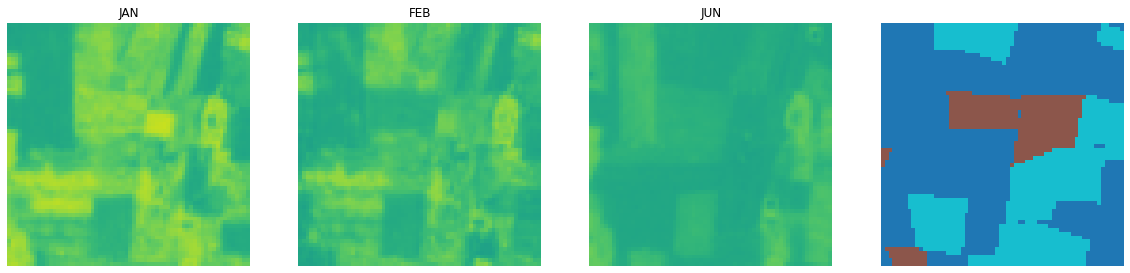

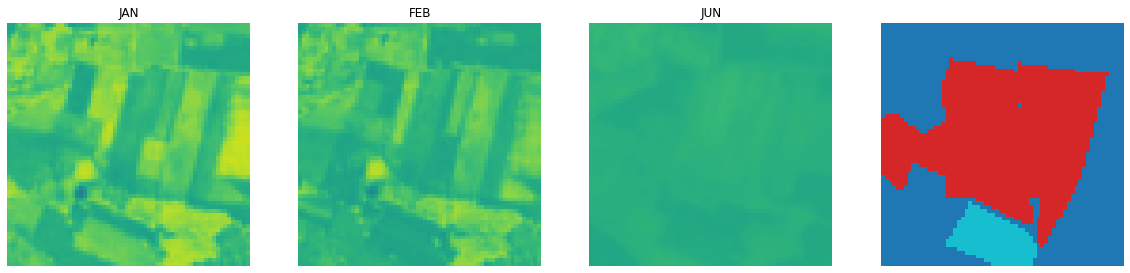

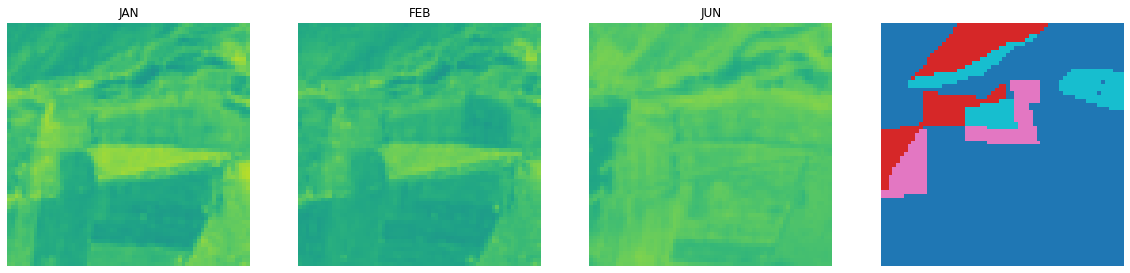

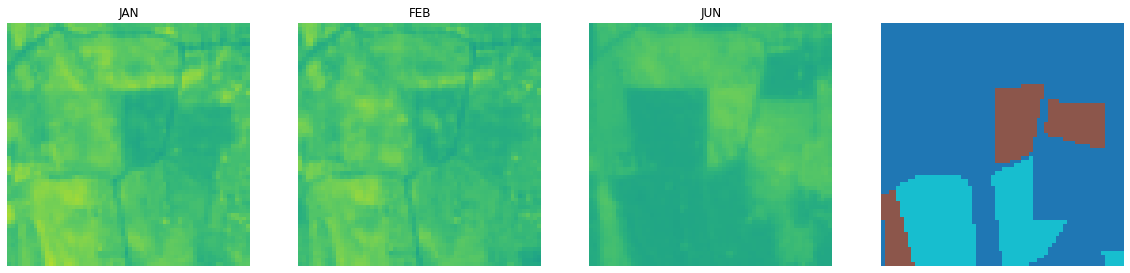

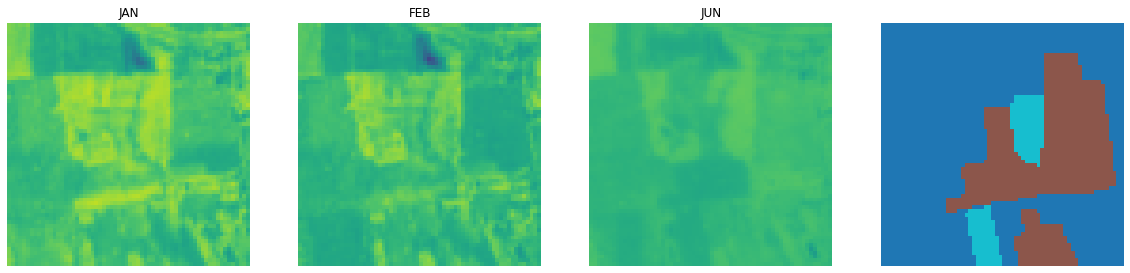

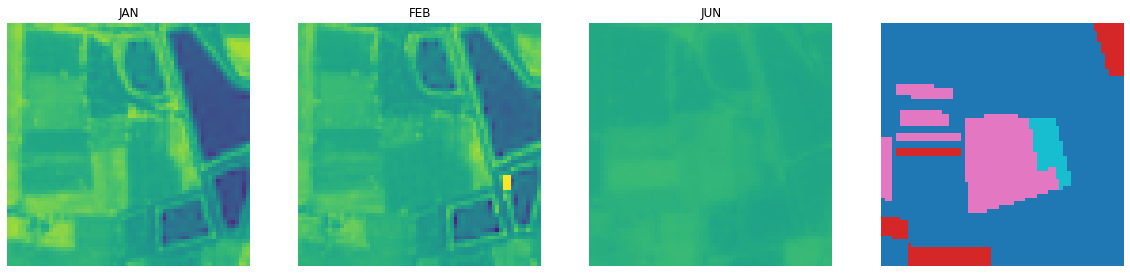

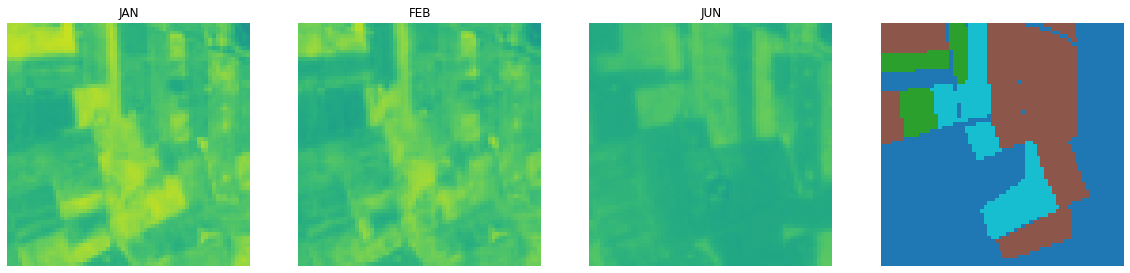

In [6]:
for _ in range(10):
    i = np.random.randint(0, label_patches.shape[0])
    
    plt.figure(figsize=(20,5))
    plt.subplot(141)
    plt.imshow(ndvi_patches[i,:,:,0], vmin=-1, vmax=1)
    plt.title('JAN')
    plt.axis('off')
    plt.subplot(142)
    plt.imshow(ndvi_patches[i,:,:,1], vmin=-1, vmax=1)
    plt.title('FEB')
    plt.axis('off')
    plt.subplot(143)
    plt.imshow(ndvi_patches[i,:,:,5], vmin=-1, vmax=1)
    plt.title('JUN')
    plt.axis('off')
    plt.subplot(144)
    plt.imshow(label_patches[i], cmap='tab10')
    plt.axis('off')

In [7]:
train_idx = int(0.7 * label_patches.shape[0])
test_idx = train_idx + 1

np.save('data/processed/train_input.npy', ndvi_patches[:train_idx])
np.save('data/processed/train_labels.npy', label_patches[:train_idx])
np.save('data/processed/test_input.npy', ndvi_patches[test_idx:])
np.save('data/processed/test_labels.npy', label_patches[test_idx:])